In [8]:
import torch
import matplotlib.pyplot as plt
import os
import librosa
import numpy as np
from IPython.display import Audio

from src.train import train
from src.NSynthDataset import NSynthDataset
from src.utils import estimate_pitch

In [9]:
batch_size = 50
D_lr = 1e-6
G_lr = 1e-5
epochs = 1000
z_size = 1000

# min len =16000
sr = 8191
duration = 2

In [10]:
os.chdir('../../..')
path = 'mnt/data/public/NSynth/'

In [11]:
train_set = NSynthDataset(data_path=path, mel=True, sampling_rate=sr, duration=duration, min_class_count=10000, max_class_count=3000, pitched_z=True, z_size=z_size)#, limit=1000)

In [12]:
i = 42
w, l, z = train_set.__getitem__(i)
inst = train_set.annot.loc[train_set.fnames[i], 'instrument_class_str']
pitch = train_set.annot.loc[train_set.fnames[i], 'pitch']
print(inst, pitch)

organ_electronic 53


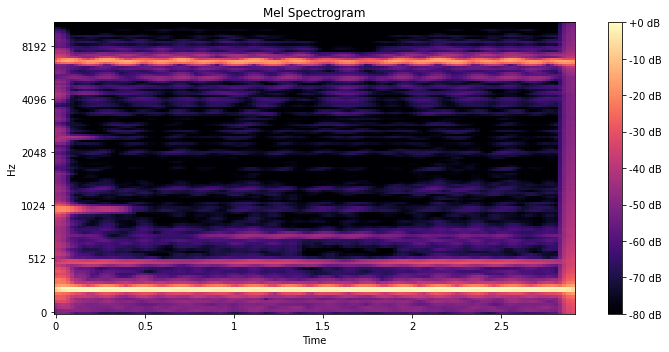

In [13]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(librosa.power_to_db(w, ref=np.max),  y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [14]:
g_loss, d_loss, G, D = train(train_set, 
                             batch_size, 
                             D_lr, 
                             G_lr, 
                             epochs, 
                             z_size, 
                             d_updates=5, 
                             g_updates=1, 
                             flip_prob=0.1, 
                             ph=0, 
                             loss='wasserstein', 
                             save_dir='users/adcy353/GANs-Conditional-Audio-Synthesis/models/avpool/',
                             pretr_epochs=0,
                             save_epochs=10,
                             lambda_gp=100
                            )#, val_set=val_set)


Saving train params...
Working on cuda
Loading data...
Creating SpecGAN...
SpecGANGenerator(
  (avgpool): AdaptiveMaxPool2d(output_size=(128, 128))
  (fc): Linear(in_features=1005, out_features=16384, bias=True)
  (deconv): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (9): Tanh()
  )
)
SpecGANDiscriminator(
  (label_fc): Linear(in_features=5, out_features=128, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (conv)

  0%|          | 0/300 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (126) must match the size of tensor b (128) at non-singleton dimension 2

In [ ]:
with open(f'{save_dir}loss_hist.txt', 'w') as f:
    f.write(f'G: {g_loss}\n D: {d_loss}')

In [ ]:
#fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#ax[0].plot(range(epochs), g_loss)
#ax[1].plot(range(epochs), d_loss)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(range(epochs), d_loss, label='Discriminator loss')
ax.plot(range(epochs), g_loss, label='Generator loss')
ax.legend()

In [ ]:
#z = torch.rand(1, 100).to(torch.device('cuda')
G.eval()
s = G.forward(z.unsqueeze(0).to(torch.device('cuda')), l.unsqueeze(0).to(torch.device('cuda')))
s.to(torch.device('cpu'))
s = s.detach().cpu()
Audio(s, rate=sr)

In [ ]:
estimate_pitch(s, sr)

1e-3, 0, 25, no sch -> gdom